### Simulaciones de trayectorías (plásticos)


## Introducción

Comprender las trayectorias en el océano es importante para varias aplicaciones, como la contaminación marina por plásticos, pero también para otros contaminantes oceánicos como los derrames de petróleo o para estudios de ecología marina para comprender la conectividad de las especies marinas. Las simulaciones Lagrangianas son una  herramienta potente para obtener trayectorias marinas. Una de las herramientas de software abierto que existen es OceanParcels. Usando como entrada campos de velocidad, como los que vimos en el tutorial anterior (por ejemplo, productos altimetría satelital de la superficie del mar), podemos obtener fácilmente trayectorias de partículas con diferentes características.

<!-- Here will look at an example of a Lagrangian simulation..... -->

¿Quieres saber más detalles sobre OceanParcels? Más info. [aquí].(https://docs.oceanparcels.org/en/latest/index.html)


También puede explorar el simulador en línea [plastic adrift](https://plasticadrift.org/)!!

## ¿Cómo funciona?

### Características de la simulación:
* Duración (runtime): 30 días
* Número de partículas: 144 (1 por punto de malla en nuestra subregión de estudio)

In [62]:

%matplotlib inline

import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import xarray as xr
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [63]:
import parcels
parcels.__version__ # para saber la versión del paquete parcels que estamos usando

'3.1.0'

# Campos de entrada (input fields):

Usaremos los campos de velocidad de derivados de datos de satélite obtenidos de la plataforma [Copernicus Marine Service](https://marine.copernicus.eu/).

In [66]:
filedir = '/home/jovyan/shared/ohwe24_hackaton/datos_corrientes_sat/'

In [67]:
import os

# Mostrar el directorio actual
print(os.getcwd())

/home/jovyan/ohwe24-proy2-plasticos


In [68]:
!ls


LICENSE
README.md
Untitled.ipynb
cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-I_20230101.nc
imagenes
lag_simu_pset_A_test01.zarr
proyecto2.ipynb


In [70]:
ds_m = xr.open_dataset(filedir + "dt_global_allsat_phy_l4_20180906_20210726.nc")

## Primero cargamos un fichero de ejemplo::

In [71]:
ds_m

<xarray.Dataset> Size: 83MB
Dimensions:         (time: 1, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time            (time) datetime64[ns] 8B 2018-09-06
  * latitude        (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 8B 0 1
Data variables: (12/14)
    crs             int32 4B ...
    lat_bnds        (latitude, nv) float32 6kB ...
    lon_bnds        (longitude, nv) float32 12kB ...
    sla             (time, latitude, longitude) float64 8MB ...
    err_sla         (time, latitude, longitude) float64 8MB ...
    ugosa           (time, latitude, longitude) float64 8MB ...
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 8MB ...
    adt             (time, latitude, longitude) float64 8MB ...
    ugos            (time, latitude, longitude) float64 8MB ...
    vgos            (time, latitude, longitude) float64 8MB ...
    flag_ice        (time, latitude, longitude) float64 8MB ...
    tpa_correction  (time) float64 8B ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2018-09-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-09-05T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

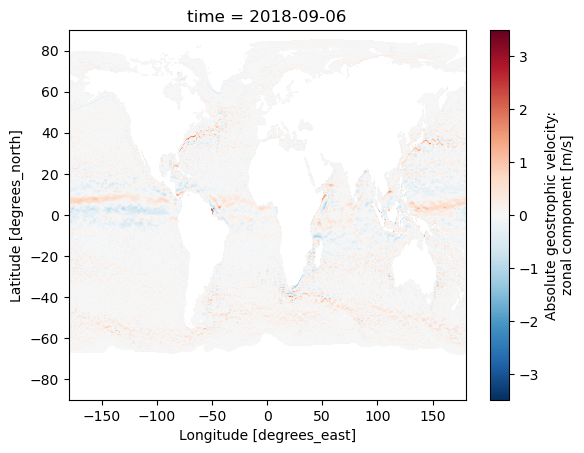

In [6]:
ds_m.ugos[0,:,:].plot()

## Seleccionamos una subzona:

In [7]:
lon_min = -100
lon_max = -75
lat_min = -10
lat_max = 10

In [8]:
ds_m_sub = ds_m.where((ds_m.longitude<lon_max)&(ds_m.longitude>lon_min)&(ds_m.latitude<lat_max)&(ds_m.latitude>lat_min), drop=True)


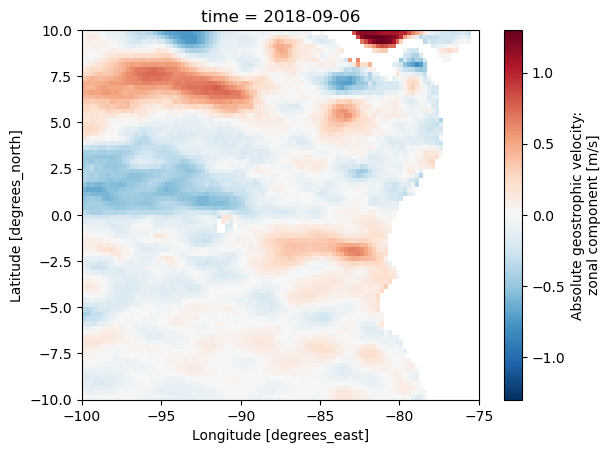

In [9]:
ds_m_sub.ugos[0,:,:].plot()

## Cargamos el "fieldset" (campo de velocidad) para las simulaciones:

In [10]:
ficheros = {'U': filedir + "dt_global_allsat_phy_l4_201809[0-1]?_*.nc",
             'V': filedir + "dt_global_allsat_phy_l4_201809[0-1]?_*.nc"}


### Usamos la velocidad Euleriana, así que elegimos las variables ugos y vgos:

In [11]:
variables = {'U': 'ugos',
             'V': 'vgos'}

dimensiones = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [12]:
fieldset = FieldSet.from_netcdf(ficheros, variables, dimensiones, deferred_load=False)

# Definimos los parámetros de la simulación:

## ¿Cuántas y dónde queremos lanzar las partículas?

### Opción A) Definimos las longitudes y latitudes.
### Por ejemple, lanzamos las partículas sobre una línea:

In [13]:
lat1D = np.arange(-0.1,0.1, 0.1) # (inicio, fin + incremento, incremento)
lon1D = np.ones_like(lat1D) * -90.

pset_A = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon1D, lat=lat1D)


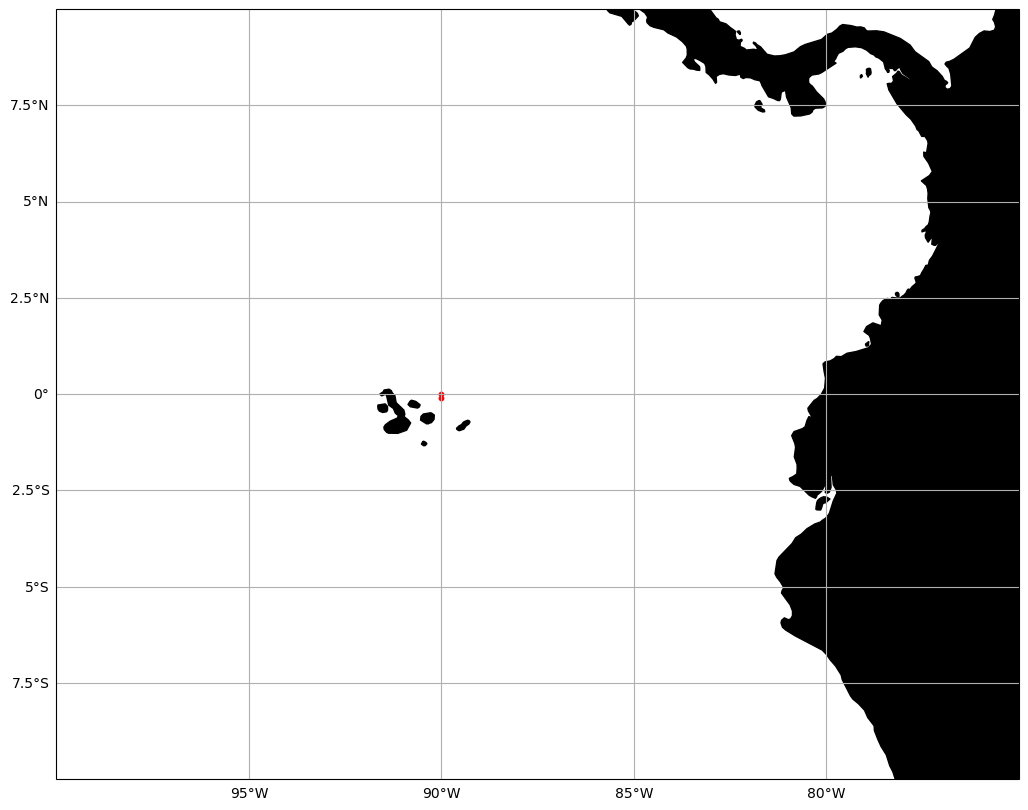

In [14]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.scatter(pset_A.lon, pset_A.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min, lon_max])
ax1.set_ylim([lat_min, lat_max])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Otros parámetros:

In [15]:
runtime_days = 10

## Simulación con set de partículas A:

In [16]:
fichero_salida_A = "lag_simu_pset_A_test01" # fichero guardado en formato .zarr que es equivalente a netcdf (.nc)

In [17]:
output_file = pset_A.ParticleFile(name=fichero_salida_A, outputdt=timedelta(hours=24))
pset_A.execute(pset_A.Kernel(AdvectionRK4),
             runtime=timedelta(days=runtime_days),
             dt=timedelta(minutes=25),
             output_file=output_file)

INFO: Output files are stored in lag_simu_pset_A_test01.zarr.
100%|██████████| 864000.0/864000.0 [00:04<00:00, 199403.08it/s]


In [18]:
!ls -trl # para ver los nuevos ficheros en nuestro directorio

total 568
-rw-r--r-- 1 jovyan jovyan   1079 Nov 25 17:50 LICENSE
-rw-r--r-- 1 jovyan jovyan   1537 Nov 25 17:50 README.md
-rw-r--r-- 1 jovyan jovyan 567605 Nov 26 16:54 proyecto2.ipynb
drwxr-xr-x 8 jovyan jovyan   4096 Nov 26 16:56 lag_simu_pset_A_test01.zarr


# Echemos un vistazo a las trayectorias generadas:

In [20]:
ds = xr.open_dataset("lag_simu_pset_A_test01.zarr")

/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/.pixi/envs/default/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [21]:
ds

<xarray.Dataset> Size: 456B
Dimensions:     (trajectory: 2, obs: 10)
Coordinates:
  * obs         (obs) int32 40B 0 1 2 3 4 5 6 7 8 9
  * trajectory  (trajectory) int64 16B 0 1
Data variables:
    lat         (trajectory, obs) float32 80B ...
    lon         (trajectory, obs) float32 80B ...
    time        (trajectory, obs) datetime64[ns] 160B ...
    z           (trajectory, obs) float32 80B ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.1.0

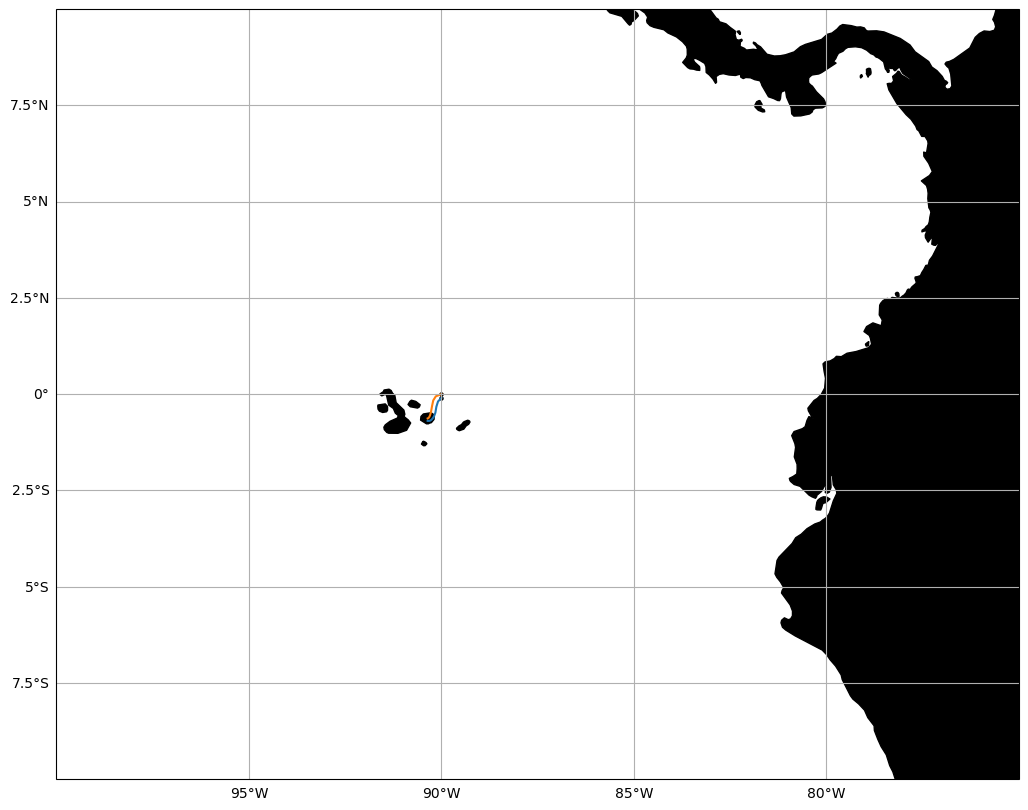

In [22]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min, lon_max])
ax1.set_ylim([lat_min, lat_max])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Graficamos las partículas en el último paso de tiempo con la velocidad zonal de fondo:

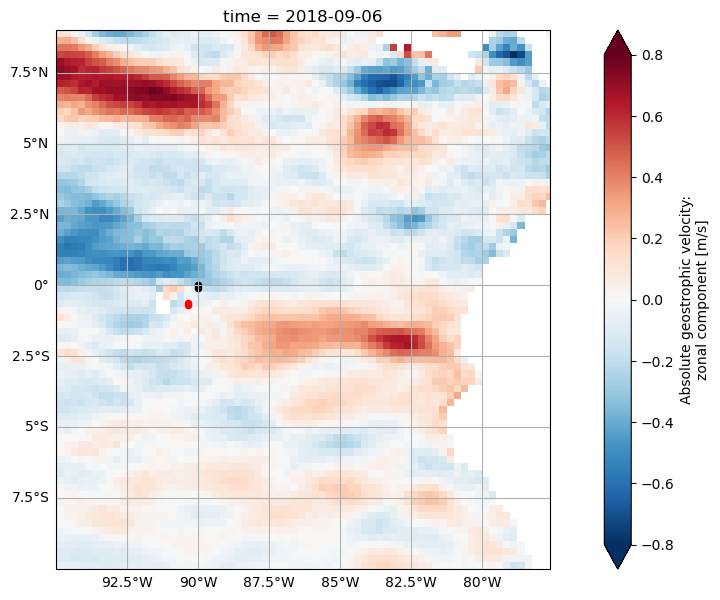

In [23]:
plt.figure(figsize=(14,7))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ds_m.ugos[0,:,:].plot(vmin=-.8, vmax=.8, cmap='RdBu_r')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=20, transform=ccrs.PlateCarree(), label='End')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=20, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([-95, -77.6])
ax1.set_ylim([lat_min, 9])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# Referencias

Laura Gomez-Navarro, & Paul Hargous. (2024). IMEDEA-AP-LAB/MASS24_Altimetry_tutorial: v1.0.0 (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.13962687